In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import procrustes
from scipy.spatial.distance import correlation, pdist, squareform
from scipy.stats import linregress
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
all_replicates = [
    "replicate-1",
    "replicate-2",
    "replicate-3",
    "replicate-4",
    "replicate-5",
]

In [34]:
mses = []
for n_components in [4]: #[2, 3, 4, 6]:
    print()
    print(f"{n_components} components")
    
    for replicate_train in all_replicates:
        print()
        print(f"training replicate: {replicate_train}")
        replicates_test = sorted(set(all_replicates) - set([replicate_train]))
    
        genetic_distances_train = pd.read_csv(
            f"simulations/influenza-like/no-reassortment/{replicate_train}/distance_matrix.csv",
            index_col=0,
        )
        genetic_distances_train = squareform(genetic_distances_train)        
        
        embedding_train = pd.read_csv(
            f"simulations/influenza-like/no-reassortment/{replicate_train}/gridsearch/embedding_components~{n_components}/perplexity~nan/learning_rate~nan/method~mds/nearest_neighbors~nan/min_dist~nan.csv",
            index_col=0,
        )
        
        for replicate_test in replicates_test:
            print(f"test replicate: {replicate_test}")
            
            # Load genetic and Euclidean distances.
            genetic_distances_test = pd.read_csv(
                f"simulations/influenza-like/no-reassortment/{replicate_test}/distance_matrix.csv",
                index_col=0,
            )
            genetic_distances_test = squareform(genetic_distances_test)
            
            embedding_test = pd.read_csv(
                f"simulations/influenza-like/no-reassortment/{replicate_test}/gridsearch/embedding_components~{n_components}/perplexity~nan/learning_rate~nan/method~mds/nearest_neighbors~nan/min_dist~nan.csv",
                index_col=0,
            )

            # Project test embedding into training embedding space.
            embedding_train_centered, embedding_test_projected, disparity = procrustes(
                embedding_train,
                embedding_test,
            )
            print(f"disparity: {disparity}")

            euclidean_distances_train = pdist(embedding_train_centered)
            euclidean_distances_test = pdist(embedding_test_projected)
            
            model = linregress(genetic_distances_train, euclidean_distances_train)
            print(f"model: {model}")
            
            # Estimate Euclidean distances for test data from the model.
            estimated_euclidean_distances_test = model.intercept + (model.slope * genetic_distances_test)

            # Calculate the mean squared error.
            mse = ((euclidean_distances_test - estimated_euclidean_distances_test) ** 2).sum() / euclidean_distances_test.shape[0]

            mses.append({
                "n_components": n_components,
                "replicate_train": replicate_train,
                "replicate_test": replicate_test,
                "mse": mse,
            })


4 components

training replicate: replicate-1
test replicate: replicate-2
disparity: 0.8902179772812
model: LinregressResult(slope=0.0005587215769283212, intercept=-0.00263313921087387, rvalue=0.9774704225320431, pvalue=0.0, stderr=6.826299591838858e-08, intercept_stderr=3.7392745512795425e-06)
test replicate: replicate-3
disparity: 0.9058010334211931
model: LinregressResult(slope=0.0005587215769283212, intercept=-0.00263313921087387, rvalue=0.9774704225320431, pvalue=0.0, stderr=6.826299591838858e-08, intercept_stderr=3.7392745512795425e-06)
test replicate: replicate-4
disparity: 0.7012977483795516
model: LinregressResult(slope=0.0005587215769283212, intercept=-0.00263313921087387, rvalue=0.9774704225320431, pvalue=0.0, stderr=6.826299591838858e-08, intercept_stderr=3.7392745512795425e-06)
test replicate: replicate-5
disparity: 0.7895823298550679
model: LinregressResult(slope=0.0005587215769283212, intercept=-0.00263313921087387, rvalue=0.9774704225320431, pvalue=0.0, stderr=6.826299

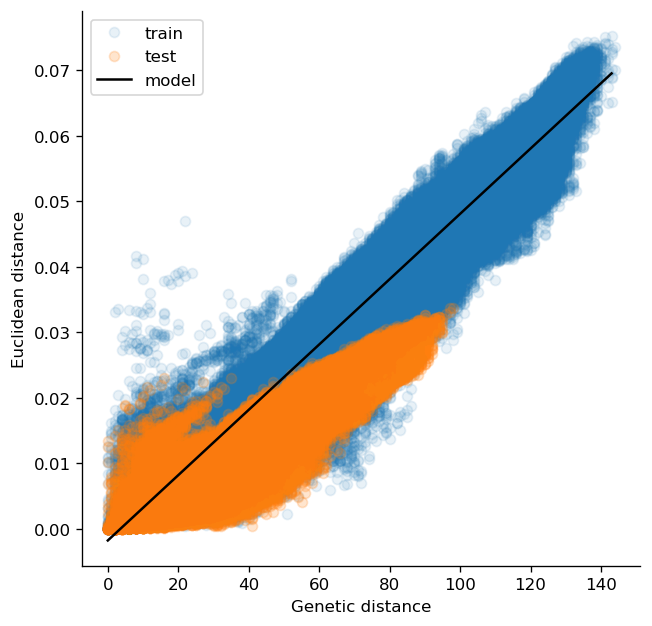

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
ax.plot(
    genetic_distances_train,
    euclidean_distances_train,
    "o",
    alpha=0.1,
    label="train",
)

ax.plot(
    genetic_distances_test,
    euclidean_distances_test,
    "o",
    alpha=0.2,
    label="test",
)

model_x = np.arange(0, genetic_distances_train.max())
model_y = model.intercept + (model.slope * model_x)
ax.plot(
    model_x,
    model_y,
    "-",
    color="black",
    label="model",
)

ax.legend()

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance")

sns.despine()

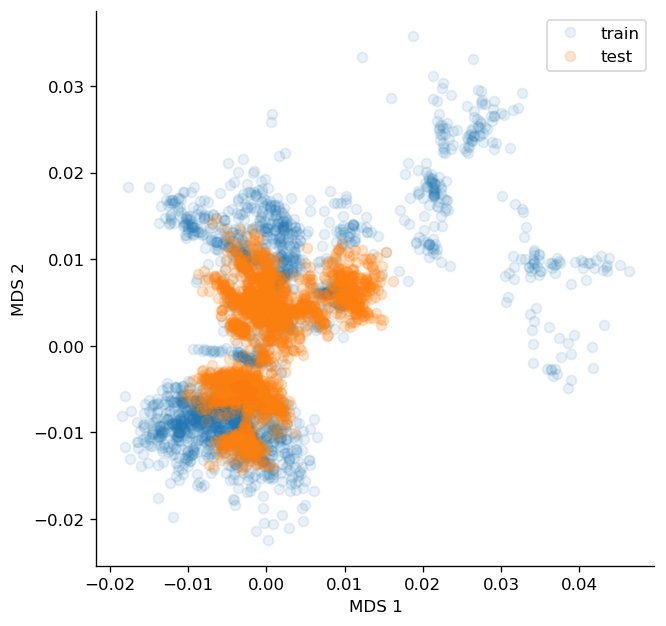

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
ax.plot(
    embedding_train_centered[:, 0],
    embedding_train_centered[:, 1],
    "o",
    alpha=0.1,
    label="train",
)

ax.plot(
    embedding_test_projected[:, 0],
    embedding_test_projected[:, 1],
    "o",
    alpha=0.2,
    label="test",
)

ax.legend()

ax.set_xlabel("MDS 1")
ax.set_ylabel("MDS 2")

sns.despine()

In [39]:
embedding_test.values

array([[ 35.64234327,  14.44519785, -11.77553749, -17.26717301],
       [ 15.9816406 ,  19.57453321, -21.21222456, -27.59279987],
       [ 27.26478639,  19.62631624, -22.56536959, -20.2729645 ],
       ...,
       [-20.6096372 , -31.62029813,  11.01508907,   4.26277643],
       [ -7.06865375, -39.1374638 ,   7.25909668,   4.83483592],
       [-21.02135144, -31.45694992,  10.96854988,   3.70442821]])

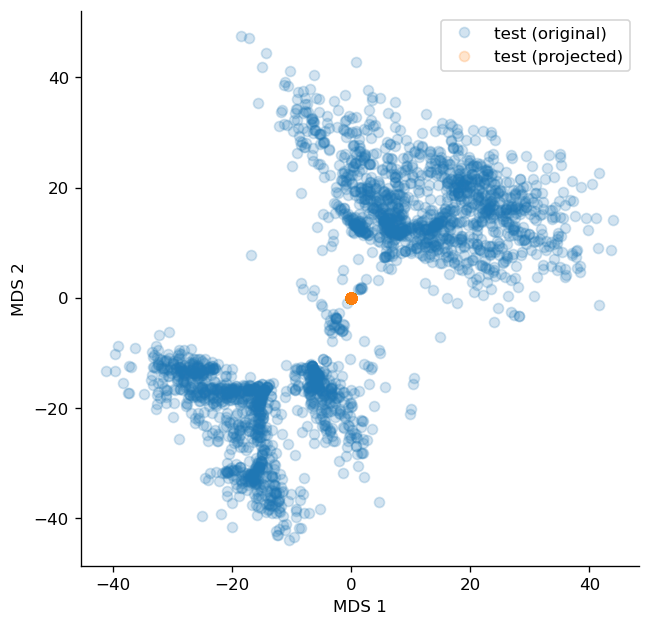

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
ax.plot(
    embedding_test.values[:, 0],
    embedding_test.values[:, 1],
    "o",
    alpha=0.2,
    label="test (original)",
)


ax.plot(
    embedding_test_projected[:, 0],
    embedding_test_projected[:, 1],
    "o",
    alpha=0.2,
    label="test (projected)",
)

ax.legend()

ax.set_xlabel("MDS 1")
ax.set_ylabel("MDS 2")

sns.despine()

In [27]:
mses_df = pd.DataFrame(mses)

In [28]:
mses_df

,n_components,replicate_train,replicate_test,mse
0,2,replicate-1,replicate-2,0.000163
1,2,replicate-1,replicate-3,0.000554
2,2,replicate-1,replicate-4,0.000032
3,2,replicate-1,replicate-5,0.000300
4,2,replicate-2,replicate-1,0.000527
...,...,...,...,...
75,6,replicate-4,replicate-5,0.000474
76,6,replicate-5,replicate-1,0.000176
77,6,replicate-5,replicate-2,0.000108
78,6,replicate-5,replicate-3,0.000412


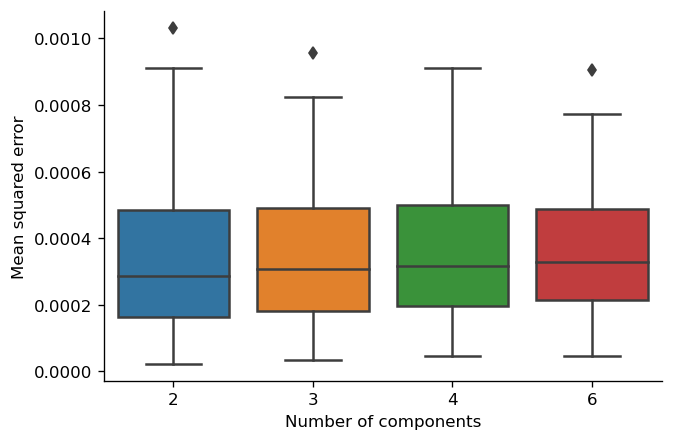

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
sns.boxplot(
    data=mses_df,
    x="n_components",
    y="mse",
    ax=ax,
)
ax.set_xlabel("Number of components")
ax.set_ylabel("Mean squared error")

sns.despine()

In [30]:
mses_df.groupby("n_components")["mse"].median()

n_components
2    0.000286
3    0.000306
4    0.000317
6    0.000328
Name: mse, dtype: float64

In [31]:
mses_df.groupby("n_components")["mse"].mean()

n_components
2    0.000353
3    0.000361
4    0.000360
6    0.000368
Name: mse, dtype: float64

In [32]:
mses_df.groupby("n_components")["mse"].count()

n_components
2    20
3    20
4    20
6    20
Name: mse, dtype: int64

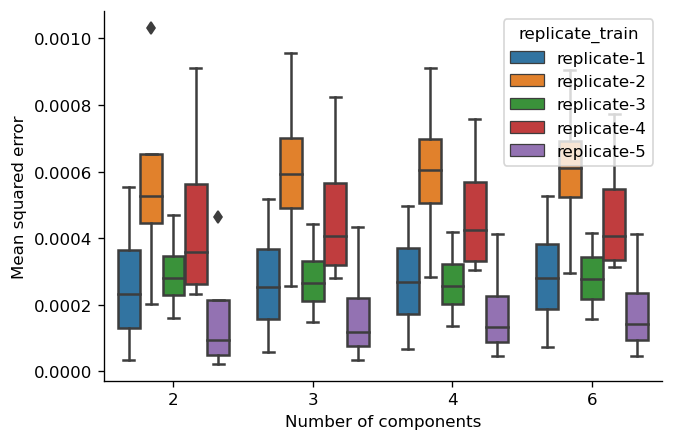

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
sns.boxplot(
    data=mses_df,
    x="n_components",
    y="mse",
    hue="replicate_train",
    ax=ax,
)
ax.set_xlabel("Number of components")
ax.set_ylabel("Mean squared error")

sns.despine()